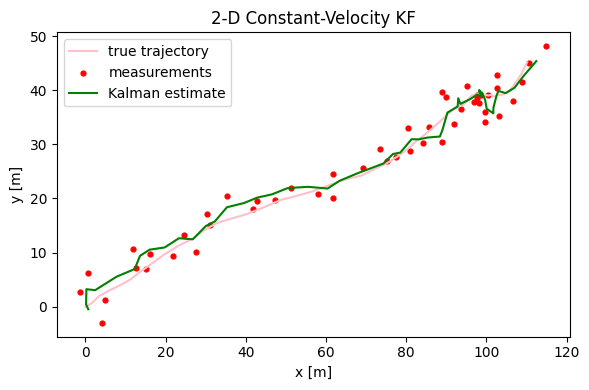

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # ---------------------------------------------------------------------
# # 0.  Simulation settings
# # ---------------------------------------------------------------------
# dt      = 1.0                  # time step  [s]
# T       = 50                   # number of steps
# np.random.seed(0)              # reproducible demo

# # True (unknown to filter) accelerations ~ N(0, σ²)
# sigma_acc = 0.3
# acc_noise = sigma_acc * np.random.randn(T, 2)

# # ---------------------------------------------------------------------
# # 1.  System matrices
# # ---------------------------------------------------------------------
# F = np.array([[1, 0, dt,  0],       # state-transition  (4×4)
#               [0, 1,  0, dt],
#               [0, 0,  1,  0],
#               [0, 0,  0,  1]])

# H = np.array([[1, 0, 0, 0],         # measurement model (2×4)
#               [0, 1, 0, 0]])

# Q = (sigma_acc**2) * np.array([      # process-noise cov (4×4)
#         [dt**4/4,       0, dt**3/2,       0],
#         [      0, dt**4/4,       0, dt**3/2],
#         [dt**3/2,       0,   dt**2,       0],
#         [      0, dt**3/2,       0,   dt**2]
#     ])

# R = np.diag([5, 5])           # meas-noise cov (2×2)

# # ---------------------------------------------------------------------
# # 2.  Generate a "ground-truth" trajectory
# # ---------------------------------------------------------------------
# true_state   = np.zeros((T, 4))     # [x, y, vx, vy]
# true_state[0] = [0, 0, 1, 0.5]      # start at origin, slight climb

# for k in range(1, T):
#     # simple Euler integration with random acceleration
#     true_state[k, 2:] = true_state[k-1, 2:] + acc_noise[k-1] * dt
#     true_state[k, 0:2] = true_state[k-1, 0:2] + true_state[k, 2:] * dt

# # noisy position measurements
# meas = true_state[:, 0:2] + np.random.multivariate_normal([0,0], R, T)

# # ---------------------------------------------------------------------
# # 3.  Kalman filter
# # ---------------------------------------------------------------------
# x_est = np.zeros((T, 4))            # filtered state
# P     = np.eye(4) * 1.0             # large-ish initial uncertainty

# for k in range(T):
#     if k == 0:
#         x_pred = x_est[0]           # start at origin, zero vel
#         P_pred = P
#     else:
#         # ------- prediction ----------
#         x_pred = F @ x_est[k-1]
#         P_pred = F @ P @ F.T + Q

#     # ------- innovation -------------
#     y_t   = meas[k] - (H @ x_pred)              # residual
#     S_t   = H @ P_pred @ H.T + R                # residual covariance
#     K_t   = P_pred @ H.T @ np.linalg.inv(S_t)   # Kalman gain

#     # ------- update -----------------
#     x_est[k] = x_pred + K_t @ y_t
#     P        = (np.eye(4) - K_t @ H) @ P_pred

# # ---------------------------------------------------------------------
# # 4.  Visualise
# # ---------------------------------------------------------------------
# plt.figure(figsize=(6,4))
# plt.plot(true_state[:,0],  true_state[:,1],  label='true trajectory', color = 'pink')
# plt.scatter(meas[:,0],     meas[:,1],  s=12, label='measurements', color = 'red')
# plt.plot(x_est[:,0],       x_est[:,1], label='Kalman estimate', color = 'green')
# plt.xlabel('x [m]'); plt.ylabel('y [m]'); plt.title('2-D Constant-Velocity KF')
# plt.legend(); plt.tight_layout()
# plt.show()


In [ ]:
# # --- 3.5 Compute RMSEs ---
# # RMSE of Kalman estimates vs true trajectory
# rmse_kf   = np.sqrt(np.mean((true_state[:,0:2] - x_est[:,0:2])**2))
# # RMSE of raw measurements vs true trajectory
# rmse_meas = np.sqrt(np.mean((true_state[:,0:2] - meas           )**2))

# print(f"RMSE (Kalman):      {rmse_kf:.3f} m")
# print(f"RMSE (Measurements):{rmse_meas:.3f} m")


RMSE (Kalman):      0.433 m
RMSE (Measurements):0.519 m


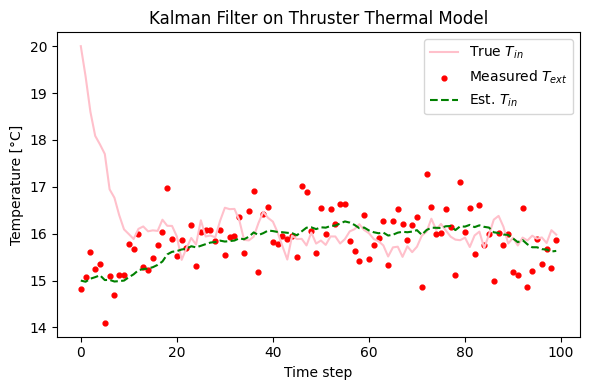

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# 0.  Simulation settings
# ---------------------------------------------------------------------
dt      = 1.0           # time step [s]
T       = 100        # number of steps
np.random.seed(0)       # reproducibility

# ---------------------------------------------------------------------
# 1.  Thermal‐model / KF parameters
# ---------------------------------------------------------------------
tau      = 5.0         # thermal time‐constant [s]
alpha    = dt / tau     # coupling coefficient

# process‐noise std devs
sigma_in  = 0.2         # °C per step internal
sigma_ext = 0.1         # °C per step external
Q = np.diag([sigma_in**2, sigma_ext**2])

# measurement‐noise std dev
sigma_meas = 0.5        # °C
R = np.array([[sigma_meas**2]])

# ---------------------------------------------------------------------
# 2.  Generate a "ground-truth" temperature trajectory
# ---------------------------------------------------------------------
true_state = np.zeros((T, 2))    # columns = [T_in, T_ext]
true_state[0] = [20.0, 15.0]      # pick some realistic start

# draw your process‐noise samples
w = np.hstack([
    sigma_in  * np.random.randn(T,1),
    sigma_ext * np.random.randn(T,1)
])

for k in range(1, T):
    Tin, Text = true_state[k-1]
    Tin_new  = Tin  + dt * ( -(Tin-Text)/tau ) + w[k-1,0]
    Text_new = Text + w[k-1,1]
    true_state[k] = [Tin_new, Text_new]

# only the external temp is measured
meas = true_state[:,1] + sigma_meas * np.random.randn(T)

# ---------------------------------------------------------------------
# 3.  Kalman filter
# ---------------------------------------------------------------------
# state = [T_in, T_ext]
x_est = np.zeros((T, 2))
P     = np.eye(2) * 10.0
x_est[0] = [15, 10]
# define F and H
F = np.array([[1-alpha, alpha],
              [0,       1   ]])
H = np.array([[0, 1]])           # pick off T_ext

for k in range(T):
    if k == 0:
        x_pred = x_est[0]        # starts at [0,0] unless you change it
        P_pred = P
    else:
        # prediction
        x_pred = F @ x_est[k-1]
        P_pred = F @ P @ F.T + Q

    # innovation
    y = meas[k] - (H @ x_pred)          # scalar residual
    S = H @ P_pred @ H.T + R            # scalar cov
    K = P_pred @ H.T @ np.linalg.inv(S) # 2×1 gain

    # update
    x_est[k] = x_pred + (K @ y).ravel()
    P        = (np.eye(2) - K @ H) @ P_pred

# ---------------------------------------------------------------------
# 4.  Visualise
# ---------------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(true_state[:,0],  label='True $T_{in}$', color = 'pink')
# plt.plot(true_state[:,1],  label='True $T_{ext}$')
plt.scatter(range(T), meas,  s=12, label='Measured $T_{ext}$', color='red')
plt.plot(x_est[:,0],      '--', label='Est. $T_{in}$', color = 'green')
# plt.plot(x_est[:,1],      '--', label='Est. $T_{ext}$')
plt.xlabel('Time step')
plt.ylabel('Temperature [°C]')
plt.title('Kalman Filter on Thruster Thermal Model')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# --- 3.5 Compute RMSEs ---
# RMSE of Kalman estimates vs true trajectory, for each state
rmse_in_kf  = np.sqrt(np.mean((true_state[:,0] - x_est[:,0])**2))
# rmse_ext_kf = np.sqrt(np.mean((true_state[:,1] - x_est[:,1])**2))

# # RMSE of raw measurements vs true external temperature
# rmse_ext_meas = np.sqrt(np.mean((true_state[:,1] - meas)**2))

# print(f"RMSE (Kalman, internal): {rmse_in_kf:.3f} °C")
# # print(f"RMSE (Kalman, external): {rmse_ext_kf:.3f} °C")
# print(f"RMSE (Measurements):      {rmse_ext_meas:.3f} °C")

# baseline internal guess = raw external measurements
rmse_in_naive = np.sqrt(np.mean((true_state[:,0] - meas)**2)) # naive = t external

print(f"RMSE (Naïve internal = meas): {rmse_in_naive:.3f} °C")
print(f"RMSE (Kalman, internal):      {rmse_in_kf:.3f} °C")



RMSE (Naïve internal = meas): 1.102 °C
RMSE (Kalman, internal):      1.021 °C


RMSE (Kalman, internal):  1.012 °C
RMSE (Newton predictor):  1.018 °C
RMSE (Measurement):  1.102 °C


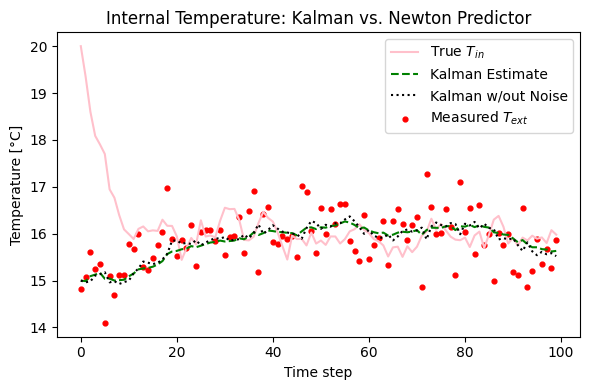

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# 0.  Simulation settings
# ---------------------------------------------------------------------
dt      = 1.0           # time step [s]
T       = 100           # number of steps
np.random.seed(0)       # reproducibility

# ---------------------------------------------------------------------
# 1.  Thermal‐model / KF parameters
# ---------------------------------------------------------------------
tau      = 5.0          # thermal time‐constant [s]
alpha    = dt / tau     # coupling coefficient

# process‐noise std devs
sigma_in  = 0.2         # °C per step internal
sigma_ext = 0.1         # °C per step external
Q = np.diag([sigma_in**2, sigma_ext**2])

# measurement‐noise std dev
sigma_meas = 0.5        # °C
R = np.array([[sigma_meas**2]])

# ---------------------------------------------------------------------
# 2.  Generate a "ground-truth" temperature trajectory
# ---------------------------------------------------------------------
true_state = np.zeros((T, 2))    # columns = [T_in, T_ext]
true_state[0] = [20.0, 15.0]      # pick some realistic start

# draw your process‐noise samples
w = np.hstack([
    sigma_in  * np.random.randn(T,1),
    sigma_ext * np.random.randn(T,1)
])

for k in range(1, T):
    Tin, Text = true_state[k-1]
    Tin_new  = Tin  + dt * (-(Tin-Text)/tau) + w[k-1,0]
    Text_new = Text + w[k-1,1]
    true_state[k] = [Tin_new, Text_new]

# only the external temp is measured
meas = true_state[:,1] + sigma_meas * np.random.randn(T)

# ---------------------------------------------------------------------
# 3.  Kalman filter
# ---------------------------------------------------------------------
# state = [T_in, T_ext]
x_est = np.zeros((T, 2))
P     = np.eye(2) * 10.0
x_est[0] = [15, 10]

# define F and H
F = np.array([[1-alpha, alpha],
              [0,       1   ]])
H = np.array([[0, 1]])           # pick off T_ext

for k in range(1, T):
    # prediction
    x_pred = F @ x_est[k-1]
    P_pred = F @ P @ F.T + Q

    # innovation
    y = meas[k] - (H @ x_pred)
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)

    # update
    x_est[k] = x_pred + (K @ y).ravel()
    P        = (np.eye(2) - K @ H) @ P_pred

# ---------------------------------------------------------------------
# 4.  Pure Newton-cooling predictor (no Kalman update)
# ---------------------------------------------------------------------
Tin_pred = np.zeros(T)
Tin_pred[0] = 15.0  # same initial guess as the filter

for k in range(1, T):
    # forward Euler of Newton's cooling, using raw external measurement
    Tin_pred[k] = Tin_pred[k-1] + dt * (-(Tin_pred[k-1] - meas[k-1]) / tau)

# ---------------------------------------------------------------------
# 5.  Compute RMSEs
# ---------------------------------------------------------------------
rmse_kf   = np.sqrt(np.mean((true_state[:,0] - x_est[:,0])**2))
rmse_pred = np.sqrt(np.mean((true_state[:,0] - Tin_pred)**2))
rmse_meas = np.sqrt(np.mean((true_state[:,0] - meas)**2))


print(f"RMSE (Kalman, internal):  {rmse_kf:.3f} °C")
print(f"RMSE (Newton predictor):  {rmse_pred:.3f} °C")
print(f"RMSE (Measurement):  {rmse_meas:.3f} °C")

# ---------------------------------------------------------------------
# 6.  Visualise
# ---------------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(true_state[:,0],    label='True $T_{in}$',      color='pink')
plt.plot(x_est[:,0], '--',   label='Kalman Estimate',    color='green')
plt.plot(Tin_pred,   ':',    label='Kalman w/out Noise',   color='black')
plt.scatter(range(T), meas,  s=12, label='Measured $T_{ext}$', color='red')
plt.xlabel('Time step')
plt.ylabel('Temperature [°C]')
plt.title('Internal Temperature: Kalman vs. Newton Predictor')
plt.legend()
plt.tight_layout()
plt.show()
